1. Installing MNE and MNE_CONNECTIVITY

In [1]:
!pip install mne
!pip install mne_connectivity

2. Importing modules

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import mne_connectivity
import glob
import getpass
import importlib
import functions
import spectrogram_plotting_functions
importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)

<module 'spectrogram_plotting_functions' from 'c:\\Users\\sinha\\Documents\\GitHub\\cpl_analysis_naman\\spectrogram_plotting_functions.py'>

3. Generating synthetic data to test mne

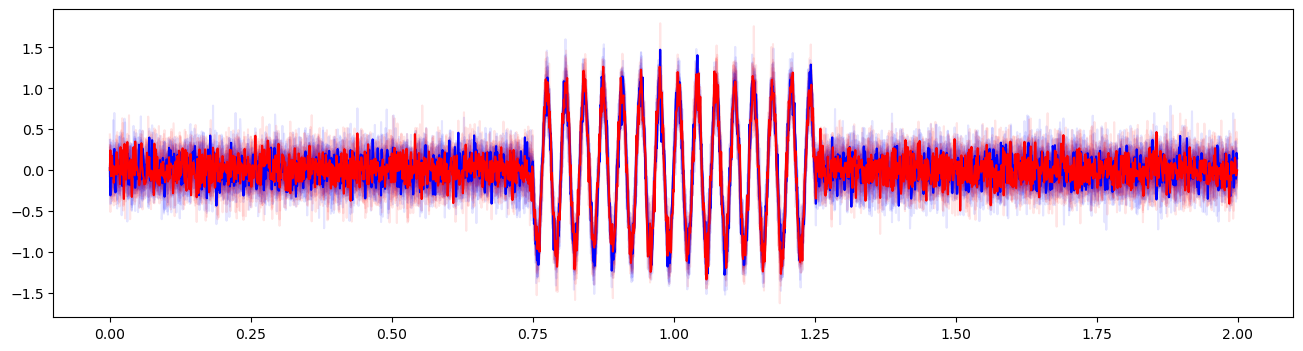

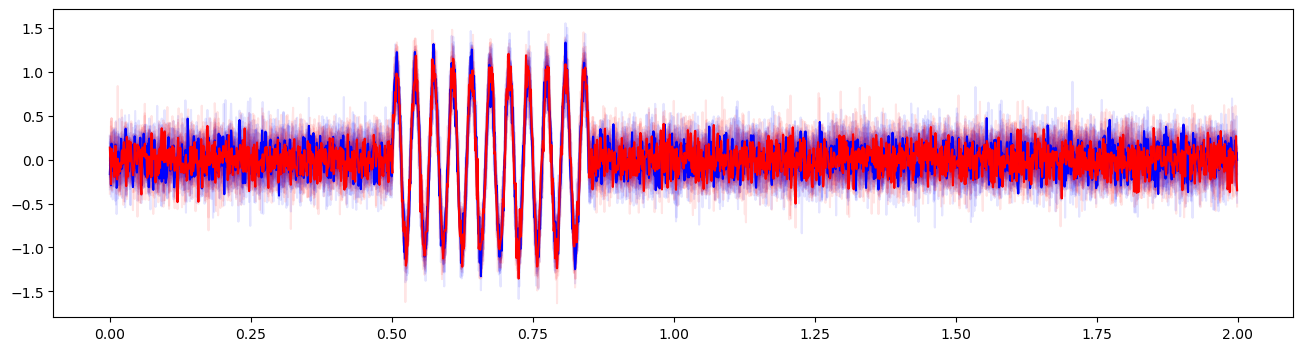

In [6]:
## Defining a function that takes the time, sampling frequency, and frequency of the oscillation and returns a epoch of generated LFP data

def generate_epoch(end_time, fs, osc_freq, osc_time_start, osc_time_end):

    times = np.arange(0, end_time, 1/fs)

    osc = np.sin(2 * np.pi * times[:] * osc_freq)[osc_time_start:osc_time_end]
    trials = 10
    epochs = np.empty((trials, 2, len(times)))
    plt.figure(figsize=(16,4))

    for trial in range(0, trials):
        lfp1 = np.random.normal(0, .2, size=times.shape)
        lfp2 = np.random.normal(0, .2, size=times.shape)
        lfp1[osc_time_start:osc_time_end] += osc
        lfp2[osc_time_start:osc_time_end] += osc  # Different amplitude for lfp2
        epochs[trial, 0, :] = lfp1
        epochs[trial, 1, :] = lfp2
        plt.plot(times, lfp1, label='lfp1', color='blue', alpha=0.1)
        plt.plot(times, lfp2, label='lfp2', color='red', alpha=0.1)
    plt.plot(times, np.mean(epochs[0,:,:], axis=0), color='blue', label='lfp1')
    plt.plot(times, np.mean(epochs[1,:,:], axis=0), color='red',label='lfp2')
    return epochs, times

thirty_epoch, thirty_times = generate_epoch(2, 1000, 30, 750, 1250)
ten_epoch, ten_times = generate_epoch(2, 1000, 30, 500, 850)

3.2 Now we test the coherence function on the generated data

Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..1.999s for estimation (2000 points)
    frequencies: 3.0Hz..99.0Hz (97 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
[Connectivity computation done]


Text(0, 0.5, 'Frequency (Hz)')

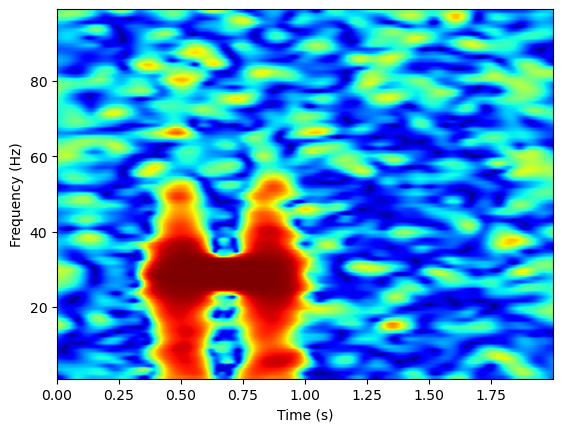

In [7]:
fs=1000
freqs = np.arange(1,100)
n_cycles = freqs/2
con = mne_connectivity.spectral_connectivity_epochs(ten_epoch, method='coh', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=True,
                                                   indices=(np.array([0]), np.array([1])))                                                   
coh = con.get_data()

plt.imshow(np.squeeze(coh), extent=[ten_times[0], ten_times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

3.2.2 Using gc method to calculate Granger Causality for simulated data

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..1.999s for estimation (2000 points)
    frequencies: 1.0Hz..100.0Hz (199 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


C:\Users\sinha\AppData\Local\Temp\ipykernel_11832\2476748449.py:5: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 1.999 s (baseline off), ~320 kB, data loaded,
 '1': 10>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(epochs_mne, method='gc', sfreq=int(fs),
C:\Users\sinha\AppData\Local\Temp\ipykernel_11832\2476748449.py:5: RuntimeWarning: fmin=1.000 Hz corresponds to 2.000 < 5 cycles based on the epoch length 2.000 sec, need at least 5.000 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  con = mne_connectivity.spectral_connectivity_epochs(epochs_mne, method='gc', sfreq=int(fs),
100%|██████████| frequency blocks : 199/199 [00:00<00:00, 2276.70it/s]

[Connectivity computation done]


Text(0.5, 0.98, 'GC: [A => B]')

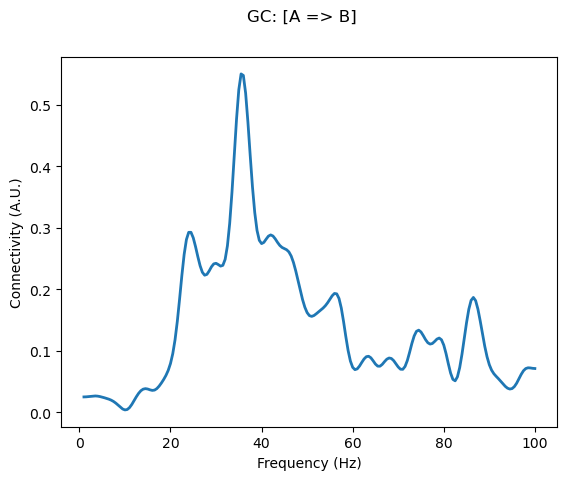

In [11]:
info=mne.create_info(ch_names=['lfp1', 'lfp2'], sfreq=fs, ch_types='eeg')
epochs_mne = mne.EpochsArray(ten_epoch, info)
indices = ([np.array([1])], [np.array([0])])  # Seed: channel 0, Target: channel 1

con = mne_connectivity.spectral_connectivity_epochs(epochs_mne, method='gc', sfreq=int(fs),
                                                    fmin=1, fmax=100, n_jobs=1,rank=(np.array([1]), np.array([1])),
                                                    verbose=True,
                                                    indices=indices)
gc = con.get_data()
freqs = con.freqs
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, gc[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("GC: [A => B]")

3.3 Trying to take a average of the coherence to see how averaging works

In [ ]:
epoch_1, times_1 = generate_epoch(2, 1000, 30, 750, 1250)
epoch_2, times_2 = generate_epoch(2, 1000, 10, 750, 1250)

fs=1000
freqs = np.arange(1,100)
n_cycles = freqs/2
con_1 = mne_connectivity.spectral_connectivity_epochs(epoch_1, method='coh', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=True,
                                                   indices=(np.array([0]), np.array([1])))

con_2 = mne_connectivity.spectral_connectivity_epochs(epoch_2, method='coh', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=True,
                                                   indices=(np.array([0]), np.array([1])))

coh_1 = con_1.get_data()
coh_2 = con_2.get_data()

print(coh_1.shape)
print(coh_2.shape)

new_array= np.array([coh_1, coh_2])
print(new_array.shape)
new_array_mean = np.mean(new_array, axis=0)
new_array_sum = np.sum(new_array, axis=0)

# Compare the mean and sum arrays element-wise
if np.array_equal(new_array_mean, new_array_sum):
    print('The mean and sum are the same')
else:
    print('The mean and sum are different')

print(new_array_mean.shape)
print(new_array_sum.shape)

# Print some values for debugging
print("Mean array values:", new_array_mean)
print("Sum array values:", new_array_sum)
# Determine the common vmin and vmax for the colormap
vmin = min(np.min(coh_1), np.min(coh_2), np.min(new_array_mean))#, np.min(new_array_sum))
vmax = max(np.max(coh_1), np.max(coh_2), np.max(new_array_mean))#, np.max(new_array_sum))


fig, axs=plt.subplots(1,3, figsize=(20,5), sharey=True)
axs = axs.flatten()

im = axs[0].imshow(np.squeeze(coh_1), extent=[times_1[0], times_1[-1], freqs[0], freqs[-1]],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axs[0].set_title('10 Hz')

axs[1].imshow(np.squeeze(coh_2), extent=[times_2[0], times_2[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axs[1].set_title('30 Hz')

# axs[2].imshow(np.squeeze(new_array_mean), extent=[times_1[0], times_1[-1], freqs[0], freqs[-1]],
#               aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
# axs[2].set_title('Mean')

axs[2].imshow(np.squeeze(new_array_sum), extent=[times_2[0], times_2[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
axs[2].set_title('Sum')

# # Plot the difference between mean and sum
# difference = new_array_sum - new_array_mean
# axs[4].imshow(np.squeeze(difference), extent=[times_1[0], times_1[-1], freqs[0], freqs[-1]],
#               aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
# axs[4].set_title('Difference (Sum - Mean)')

for ax in axs:
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')

cbar = fig.colorbar(axs[2].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence')

4. Loading up the real data

In [ ]:

user= (getpass.getuser())
print("Hello", user)

base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

In [4]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]
shuffled_event_data_df=[]
events_codes_all = {}
random_baseline_data=[]
baseline_lfp_all=[]

for file_num,file in enumerate(files):
    #if 'dk1' in file:
        
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        print(date, rat_id, task)

        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)



        if 'Keyboard' in channels:
            events = f['Keyboard']
        elif 'keyboard' in channels:
            events = f['keyboard']
        elif 'memory' in channels:
            events = f['memory']
        elif 'Memory' in channels:
            events = f['Memory']

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = functions.generate_epochs_with_first_event(events_codes, events_times)
        #epochs = functions.generate_specific_num_of_epochs_with_first_event(events_codes, events_times,5)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        all_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels))
        print(all_channels)
        
        mne_baseline_data=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_door_after=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_dig_before=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_dig_after=np.zeros((len(epochs),len(all_channels),4000))
        
        first_event = events_times[0]
        
        for channel_num,channeli in enumerate(all_channels):
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)
                
                data_before, time, baseline_mean, baseline_std=functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                normalized_data=functions.zscore_event_data(notch_filtered_data, baseline_mean, baseline_std)

                #baseline_row=[rat_id,task,channel_id,[data_before]]
                #baseline_lfp_all.append(baseline_row)
                #normalized_data, time, data_before = functions.data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                baseline_data_truncated= data_before[-4000:]
                
                mne_baseline_data[0,channel_num,:]=list(baseline_data_truncated)
                
                total = normalized_data

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_complete_trial = functions.extract_complete_trial_data(total, time, door_timestamp, dig_timestamp, sampling_rate)
                    #Here we will extract and store the events data
                    data_door_before,data_door_after=functions.extract_door_data(total, time, door_timestamp, sampling_rate)    
                    data_dig_before, data_dig_after=functions.extract_dig_data(total,time, dig_timestamp, sampling_rate)
                    event_data_list=[data_door_before,data_door_after,data_dig_before,data_dig_after]
                    [functions.zscore_event_data(event_data, baseline_mean ,baseline_std) for event_data in event_data_list]
                    mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0])
                    mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1])
                    mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2])
                    mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3])
        if len(all_channels)>0:
            fs=2000
            freqs = np.arange(1,100)
            n_cycles = freqs/2
            info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
            mne_baseline = mne.EpochsArray(mne_baseline_data, info)
            mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
            mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
            mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
            mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
            row_list=[file_num,rat_id,task,mne_baseline,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after]
            con_data_df.append(row_list)

        # fs=2000
        # freqs = np.arange(1,100)
        # n_cycles = freqs/2
        # info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
        # mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
        # mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
        # mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
        # mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
        # row_list=[rat_id,task,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after]
        # con_data_df.append(row_list)
#baseline_lfp_all = pd.DataFrame(baseline_lfp_all, columns=['rat', 'experiment', 'channel', 'data'])
con_data_df=pd.DataFrame(con_data_df, columns=['experiment','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'])


Calculating Coherence during Baseline Time

Baseline Coherence over frequencies

In [ ]:
con_data_df_clean=con_data_df[con_data_df['rat_id']!='dk3']
BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]

task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}
bwcontext_baseline_con_data=[]
bwnocontext_baseline_con_data=[]

fs=2000
fmin=1
fmax=100
freqs = np.arange(fmin,fmax)
n_cycles = freqs/2

for task_name in task_data_dict.keys():
    task_data=task_data_dict[task_name]
    print(task_name)
    baseline_list=task_data['mne_baseline']
    #all_con_data=[]
    for single_baseline_epoch in baseline_list:
        #rat_task_data=task_data[task_data['rat_id']==rat_id]
        #single_baseline_epoch=rat_task_data['mne_baseline'].iloc[0]
        con=mne_connectivity.spectral_connectivity_time(single_baseline_epoch, method='coh', sfreq=int(fs), freqs=freqs,fmin=fmin, fmax=fmax, mode='cwt_morlet', verbose=False, n_cycles=n_cycles)
        coh = con.get_data(output='dense')
        indices = con.names
        aon_vhp_con=[]
        for i in range(coh.shape[1]):
            for j in range(coh.shape[2]):
                if 'AON' in indices[j] and 'vHp' in indices[i]:
                    aon_vhp_con.append(coh[0,i,j,:])
        aon_vhp_con_mean=np.mean(aon_vhp_con, axis=0)
        #all_con_data.append(aon_vhp_con_mean)
        if len(aon_vhp_con_mean)>0:
            if task_name=='BWcontext':
                bwcontext_baseline_con_data.append(aon_vhp_con_mean)
                print('BWcontext', len(bwcontext_baseline_con_data))
            else:
                bwnocontext_baseline_con_data.append(aon_vhp_con_mean)
                print('BWnocontext', len(bwnocontext_baseline_con_data))
        else:
            print('No data')


bwcontext_baseline_con_data_array=np.array(bwcontext_baseline_con_data, dtype=float)
bwcontext_baseline_con_data_mean=np.mean(bwcontext_baseline_con_data_array, axis=0)
bwcontext_baseline_con_data_sem=np.std(bwcontext_baseline_con_data_array, axis=0)
print(bwcontext_baseline_con_data_mean.shape, bwcontext_baseline_con_data_sem.shape)  

bwnocontext_baseline_con_data_array = np.array(bwnocontext_baseline_con_data, dtype=float)
bwnocontext_baseline_con_data_mean = np.mean(bwnocontext_baseline_con_data_array, axis=0)
bwnocontext_baseline_con_data_sem = np.std(bwnocontext_baseline_con_data_array, axis=0)
print(bwnocontext_baseline_con_data_mean.shape, bwnocontext_baseline_con_data_sem.shape)

freqs=np.arange(0,99)
fig, ax=plt.subplots(1,1, figsize=(20,5))
ax.plot(freqs, bwcontext_baseline_con_data_mean, label='BWcontext', color='blue')
ax.fill_between(freqs, bwcontext_baseline_con_data_mean-bwcontext_baseline_con_data_sem, bwcontext_baseline_con_data_mean+bwcontext_baseline_con_data_sem, color='blue', alpha=0.3)

ax.plot(freqs, bwnocontext_baseline_con_data_mean, label='BWnocontext', color='orange')
ax.fill_between(freqs, bwnocontext_baseline_con_data_mean-bwnocontext_baseline_con_data_sem, bwnocontext_baseline_con_data_mean+bwnocontext_baseline_con_data_sem, color='orange', alpha=0.3)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Coherence')
ax.set_title('Baseline Coherence AON-vHp')
ax.legend()
plt.show()


Calculating Coherence for each rat for each band in baseline time


In [ ]:
con_data_df_clean=con_data_df[con_data_df['rat_id']!='dk3']
con_data_df_clean=con_data_df_clean[con_data_df_clean['task']!='nocontext']

rat_list=['dk1', 'dk5', 'dk6']

task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}
bwcontext_baseline_con_data=[]
bwnocontext_baseline_con_data=[]

fs=2000
fmin=1
fmax=100
baseline_con_data_df=[]

baseline_list=con_data_df_clean['mne_baseline']
for index, row in con_data_df_clean.iterrows():
    single_baseline_epoch=row['mne_baseline']
    rat_id=row['rat_id']
    task=row['task']
    print(rat_id, task)
    band_row=[]
    bands_dict={'total':[1,100],'theta':[4,8],'beta':[12,30],'gamma':[30,100]}
    for band in bands_dict.keys():
        fmin=bands_dict[band][0]
        fmax=bands_dict[band][1]
        freqs = np.arange(fmin,fmax)
        n_cycles = freqs/2

        con=mne_connectivity.spectral_connectivity_time(single_baseline_epoch, method='coh', sfreq=int(fs), freqs=freqs,fmin=fmin, fmax=fmax,faverage=True, mode='cwt_morlet', verbose=False, n_cycles=n_cycles)
        coh = con.get_data(output='dense')
        indices = con.names
        aon_vhp_con=[]
        for i in range(coh.shape[1]):
            for j in range(coh.shape[2]):
                if 'AON' in indices[j] and 'vHp' in indices[i]:
                    aon_vhp_con.append(coh[0,i,j,:])
        aon_vhp_con_mean=np.mean(aon_vhp_con, axis=0)
        band_row.append(aon_vhp_con_mean)
    band_row.extend([rat_id, task])
    baseline_con_data_df.append(band_row)
baseline_con_data_df=pd.DataFrame(baseline_con_data_df, columns=['total','theta','beta','gamma', 'rat_id', 'task'])



fig, ax=plt.subplots(1,1, figsize=(20,10))
baseline_con_data_df_melted=pd.melt(baseline_con_data_df,id_vars=['rat_id','task'],value_vars=['total','theta','beta','gamma'],var_name='band',value_name='coherence')
baseline_con_data_df_melted['coherence']=baseline_con_data_df_melted['coherence'].apply(lambda x: x[0])
ax=sns.boxplot(x='band',y='coherence',hue='task',hue_order=['BWcontext','BWnocontext'],data=baseline_con_data_df_melted,showfliers=False)
ax=sns.stripplot(x='band',y='coherence',hue='task',hue_order=['BWcontext','BWnocontext'],data=baseline_con_data_df_melted,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax)
ax.set_xticklabels(['Total', 'Beta', 'Theta', 'Gamma'])
ax.set_title('AON-VHP Coherence during Baseline time')
ax.set_ylabel('Coherence')
ax.set_xlabel('')
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\baseline_coherence.png')
plt.show()

6. Making per-band coherence for each behavior event

In [19]:
import seaborn as sns
con_data_df_clean=con_data_df[con_data_df['rat_id']!='dk3']
con_data_df_clean=con_data_df_clean[con_data_df_clean['task']!='nocontext']

rat_list=['dk1', 'dk5', 'dk6']

def convert_epoch_to_coherence(epoch):
    band_dict={'theta':[4,8],'beta':[12,30],'gamma':[30,100],'total':[1,100]}
    coherence_dict={}
    for band in band_dict.keys():

        fmin=band_dict[band][0]
        fmax=band_dict[band][1]
        freqs = np.arange(fmin,fmax)
        n_cycles = freqs/2
        con=mne_connectivity.spectral_connectivity_time(epoch, method='coh', sfreq=int(fs), fmin=fmin, fmax=fmax,faverage=True, mode='cwt_morlet', verbose=False, n_cycles=n_cycles,freqs=freqs)
        coh = con.get_data(output='dense')
        indices = con.names
        aon_vhp_con=[]
        for i in range(coh.shape[1]):
            for j in range(coh.shape[2]):
                if 'AON' in indices[j] and 'vHp' in indices[i]:
                    aon_vhp_con.append(coh[0,i,j,:])
        aon_vhp_con_mean=np.mean(aon_vhp_con, axis=0)
        coherence_dict[band]=aon_vhp_con_mean[0]
    return coherence_dict
single_baseline_epoch=con_data_df_clean['mne_epoch_door_before'].iloc[0]
theta_band=[4,8]

theta_coherence=convert_epoch_to_coherence(single_baseline_epoch)
print(theta_coherence)

con_data_df_clean['coherence_door_before']=con_data_df_clean['mne_epoch_door_before'].apply(lambda x: convert_epoch_to_coherence(x))
con_data_df_clean['coherence_door_after']=con_data_df_clean['mne_epoch_door_after'].apply(lambda x: convert_epoch_to_coherence(x))
con_data_df_clean['coherence_dig_before']=con_data_df_clean['mne_epoch_dig_before'].apply(lambda x: convert_epoch_to_coherence(x))
con_data_df_clean['coherence_dig_after']=con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: convert_epoch_to_coherence(x))

C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\4256534499.py:16: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con=mne_connectivity.spectral_connectivity_time(epoch, method='coh', sfreq=int(fs), fmin=fmin, fmax=fmax,faverage=True, mode='cwt_morlet', verbose=False, n_cycles=n_cycles,freqs=freqs)
C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\4256534499.py:16: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con=mne_connectivity.spectral_connectivity_time(epoch, method='coh', sfreq=int(fs), fmin=fmin, fmax=fmax,faverage=True, mode='cwt_morlet', verbose=False, n_cycles=n_cycles,freqs=freqs)
C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\4256534499.py:16: RuntimeWarning: There were no Annotations stored in <EpochsArray | 

{'theta': 0.3343919136743516, 'beta': 0.41857812882544615, 'gamma': 0.4651352433587948, 'total': 0.4426057158097054}


C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\4256534499.py:16: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con=mne_connectivity.spectral_connectivity_time(epoch, method='coh', sfreq=int(fs), fmin=fmin, fmax=fmax,faverage=True, mode='cwt_morlet', verbose=False, n_cycles=n_cycles,freqs=freqs)
C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\4256534499.py:16: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con=mne_connectivity.spectral_connectivity_time(epoch, method='coh', sfreq=int(fs), fmin=fmin, fmax=fmax,faverage=True, mode='cwt_morlet', verbose=False, n_cycles=n_cycles,freqs=freqs)
C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\4256534499.py:16: RuntimeWarning: There were no Annotations stored in <EpochsArray | 

6.1 Plotting the Barplot

C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\3371836597.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(['Total', 'Beta', 'Theta', 'Gamma'])
C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\3371836597.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(['Total', 'Beta', 'Theta', 'Gamma'])
C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\3371836597.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(['Total', 'Beta', 'Theta', 'Gamma'])
C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\3371836597.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([

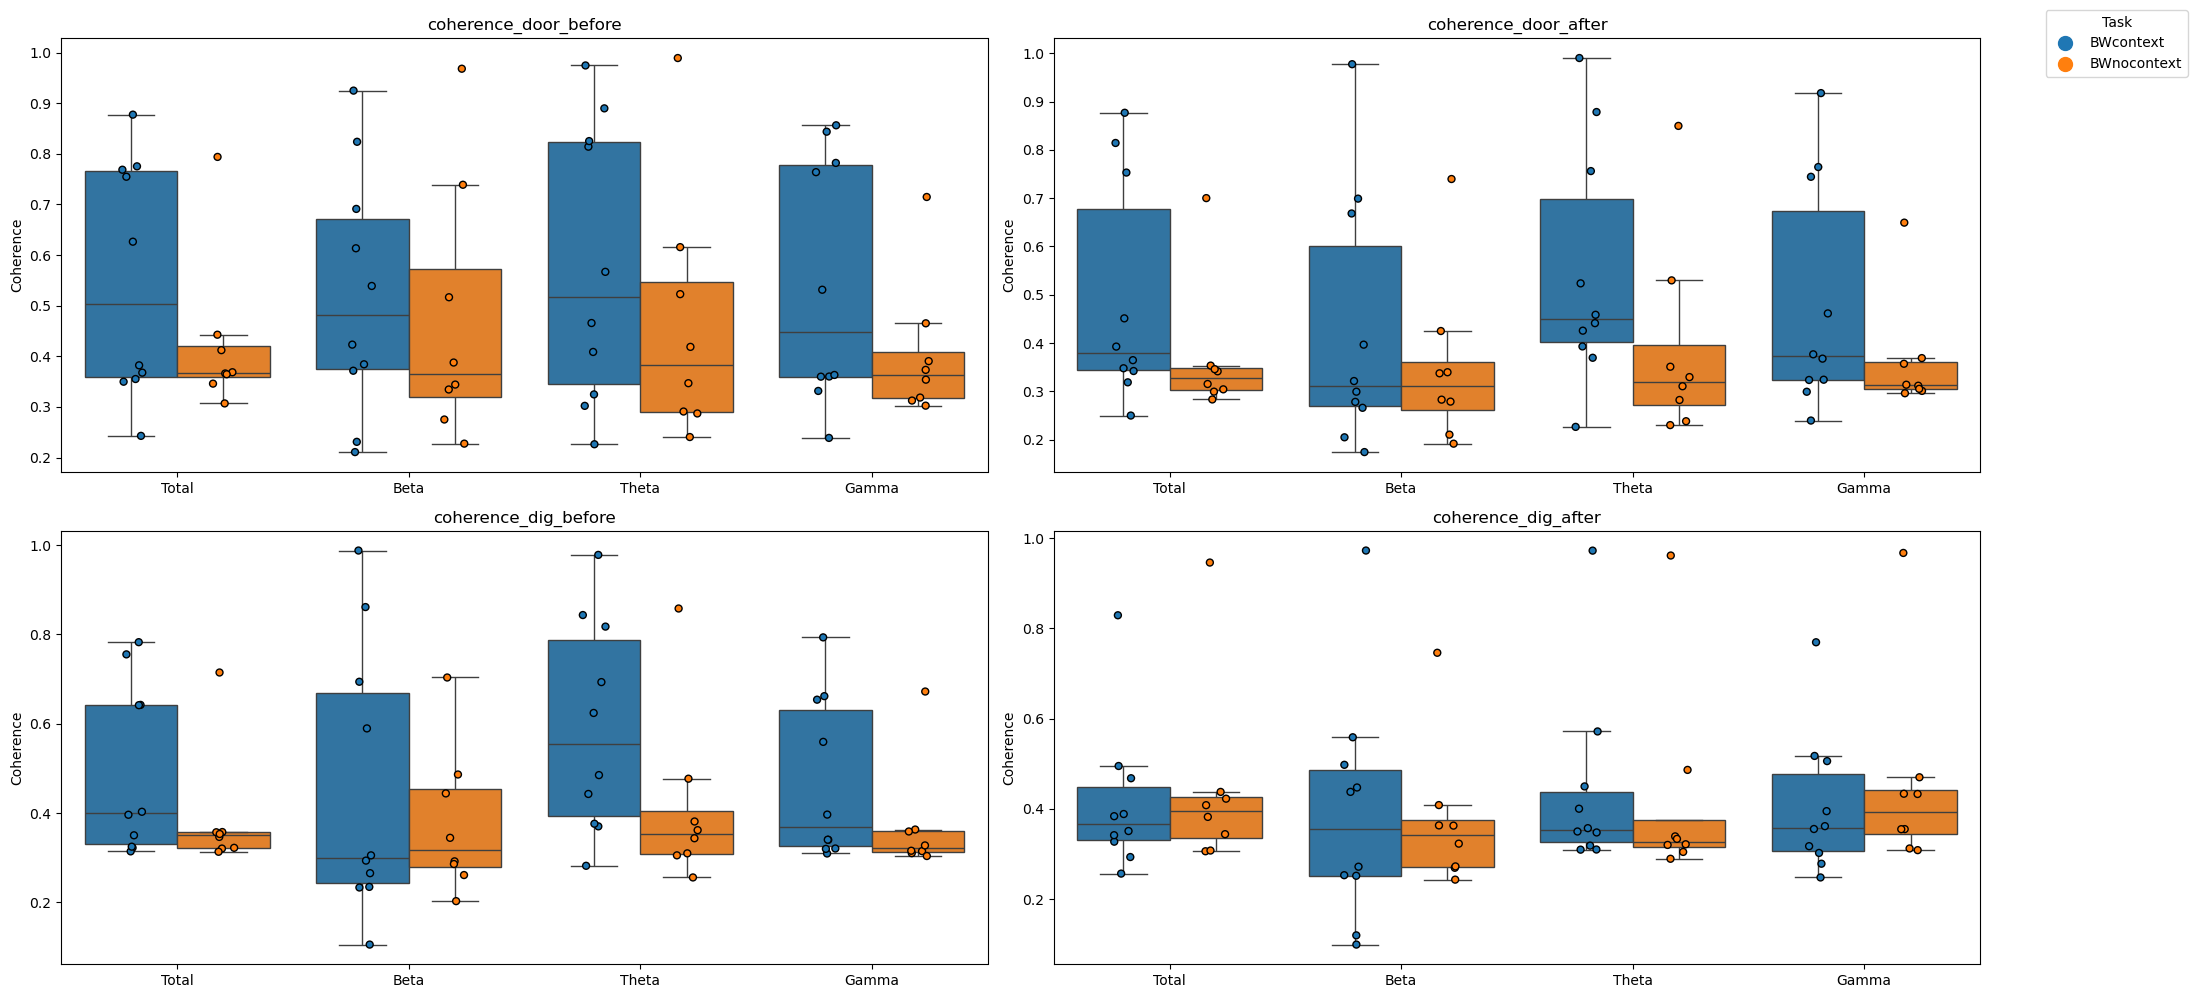

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()
for i, event in enumerate(['coherence_door_before', 'coherence_door_after', 'coherence_dig_before', 'coherence_dig_after']):
    event_data = con_data_df_clean[event]
    event_data_df = pd.DataFrame(event_data.tolist())
    event_data_df.reset_index(drop=True, inplace=True)
    event_data_df['rat_id'] = con_data_df_clean['rat_id'].reset_index(drop=True)
    event_data_df['task'] = con_data_df_clean['task'].reset_index(drop=True)
    event_data_df_melted = pd.melt(event_data_df, id_vars=['rat_id', 'task'], value_vars=['total', 'theta', 'beta', 'gamma'], var_name='band', value_name='coherence')
    sns.boxplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, showfliers=False, legend=False, ax=axs[i])
    sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs[i])
    axs[i].set_xticklabels(['Total', 'Beta', 'Theta', 'Gamma'])
    axs[i].set_title(event)
    axs[i].set_ylabel('Coherence')
    axs[i].set_xlabel('')

# Create custom legend handles and labels
from matplotlib.lines import Line2D
colors = {'BWnocontext': '#ff7f0e', 'BWcontext': '#1f77b4'}

# Create custom legend handles and labels
handles = [
    Line2D([0], [0], color=colors['BWcontext'], marker='o', linestyle='', markersize=10, label='BWcontext'),
    Line2D([0], [0], color=colors['BWnocontext'], marker='o', linestyle='', markersize=10, label='BWnocontext')
]

# Add the custom legend to the figure
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.1, 1), title='Task')
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_event_per_band.png', dpi=300)
plt.tight_layout()
plt.show()

5. Calculating Spectral connectivity and plotting it. Also plots the average of spectral connectivity in a separate plot

In [ ]:
epoch_data=mne_epoch_dig_before
con = mne_connectivity.spectral_connectivity_epochs(epoch_data, method='coh', sfreq=int(fs),
                                                   mode='cwt_morlet', cwt_freqs=freqs,
                                                   cwt_n_cycles=n_cycles, verbose=False)

coh = con.get_data(output='dense')
print(coh.shape)
indices = con.names
print("Connection indices:", indices)
fig, axs = plt.subplots(coh.shape[0],coh.shape[1] , figsize=(20, 20), sharex=True, sharey=True)
times = np.arange(0, 2, 1/fs)
aon_aon_con=[]
aon_vHp_con=[]
vHp_vHp_con=[]
for i in range(coh.shape[0]):
    for j in range(coh.shape[1]):
        axs[i,j].imshow(np.squeeze(coh[i,j,:,:]), extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Frequency (Hz)')
        axs[i,j].set_title('{} - {}'.format(indices[i], indices[j]))
        if 'AON' in indices[i] and 'AON' in indices[j]:
            aon_aon_con.append(coh[i,j,:,:])
        elif 'AON' in indices[j] and 'vHp' in indices[i]:
            aon_vHp_con.append(coh[i,j,:,:])
        elif 'vHp' in indices[i] and 'vHp' in indices[j]:
            vHp_vHp_con.append(coh[i,j,:,:])

#### Average the connections and plot them

def filtered_and_mean_con(con):
    print(' number of connections before filtering',len(con))
    filter_con=[x for x in con if x.any()>0]
    print('number of connections after filtering',len(filter_con))
    filter_con=np.array(filter_con)

    filter_con_mean=np.mean(filter_con, axis=0)
    return filter_con_mean
con_dict={'aon_aon':aon_aon_con,'aon_vHp':aon_vHp_con,'vHp_vHp':vHp_vHp_con}
fig, axs=plt.subplots(1,3, figsize=(20,5), sharey=True)
axs=axs.flatten()
for i, key in enumerate(con_dict):
    con=con_dict[key]
    con_mean=filtered_and_mean_con(con)
    axs[i].imshow(con_mean, extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].set_title(key)
plt.show()


6. Plotting average connectivity across multiple experiments for a single rat

In [ ]:
print(con_data_df.head())


In [ ]:

rat_task_con_data=con_data_df[(con_data_df['rat_id']=='dk1') & (con_data_df['task']=='BWcontext')]
mne_epoch_dig_before_list=list(rat_task_con_data['mne_epoch_dig_before'])
aon_aon_con=[]
aon_vHp_con=[]
vHp_vHp_con=[]

for epoch_data in mne_epoch_dig_before_list:
#epoch_data=mne_epoch_dig_before
    print(epoch_data)
    con = mne_connectivity.spectral_connectivity_epochs(epoch_data, method='coh', sfreq=int(fs),
                                                    mode='cwt_morlet', cwt_freqs=freqs,
                                                    cwt_n_cycles=n_cycles, verbose=False)

    coh = con.get_data(output='dense')
    print(coh.shape)
    indices = con.names
    print("Connection indices:", indices)
    fig, axs = plt.subplots(coh.shape[0],coh.shape[1] , figsize=(20, 20), sharex=True, sharey=True)
    times = np.arange(0, 2, 1/fs)
    for i in range(coh.shape[0]):
        for j in range(coh.shape[1]):
            axs[i,j].imshow(np.squeeze(coh[i,j,:,:]), extent=[times[0], times[-1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
            axs[i,j].set_xlabel('Time (s)')
            axs[i,j].set_ylabel('Frequency (Hz)')
            axs[i,j].set_title('{} - {}'.format(indices[i], indices[j]))
            if 'AON' in indices[i] and 'AON' in indices[j]:
                aon_aon_con.append(coh[i,j,:,:])
            elif 'AON' in indices[j] and 'vHp' in indices[i]:
                aon_vHp_con.append(coh[i,j,:,:])
            elif 'vHp' in indices[i] and 'vHp' in indices[j]:
                vHp_vHp_con.append(coh[i,j,:,:])

#### Average the connections and plot them

def filtered_and_mean_con(con):
    print(' number of connections before filtering',len(con))
    filter_con=[x for x in con if x.any()>0]
    print('number of connections after filtering',len(filter_con))
    filter_con=np.array(filter_con)

    filter_con_mean=np.mean(filter_con, axis=0)
    return filter_con_mean
con_dict={'aon_aon':aon_aon_con,'aon_vHp':aon_vHp_con,'vHp_vHp':vHp_vHp_con}
fig, axs=plt.subplots(1,3, figsize=(20,5), sharey=True)
axs=axs.flatten()
for i, key in enumerate(con_dict):
    con=con_dict[key]
    con_mean=filtered_and_mean_con(con)
    axs[i].imshow(con_mean, extent=[times[0], times[-1], freqs[0], freqs[-1]],
        aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].set_title(key)
plt.show()



7. Now we will compare Aon_vHp connectivity between BWcontext and BWnocontext, through events

['mne_epoch_door_before', 'mne_epoch_door_after', 'mne_epoch_dig_before', 'mne_epoch_dig_after']
['dk1' 'dk3' 'dk5' 'dk6']


C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\3768359679.py:34: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\3768359679.py:34: RuntimeWarning: fmin=1.000 Hz corresponds to 2.000 < 5 cycles based on the epoch length 2.000 sec, need at least 5.000 sec epochs or fmin=2.500. Spectrum estimate will be unreliable.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\3768359679.py:34: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  con = mne_connectivity.spectral_connectivity_epochs(event_epoch,

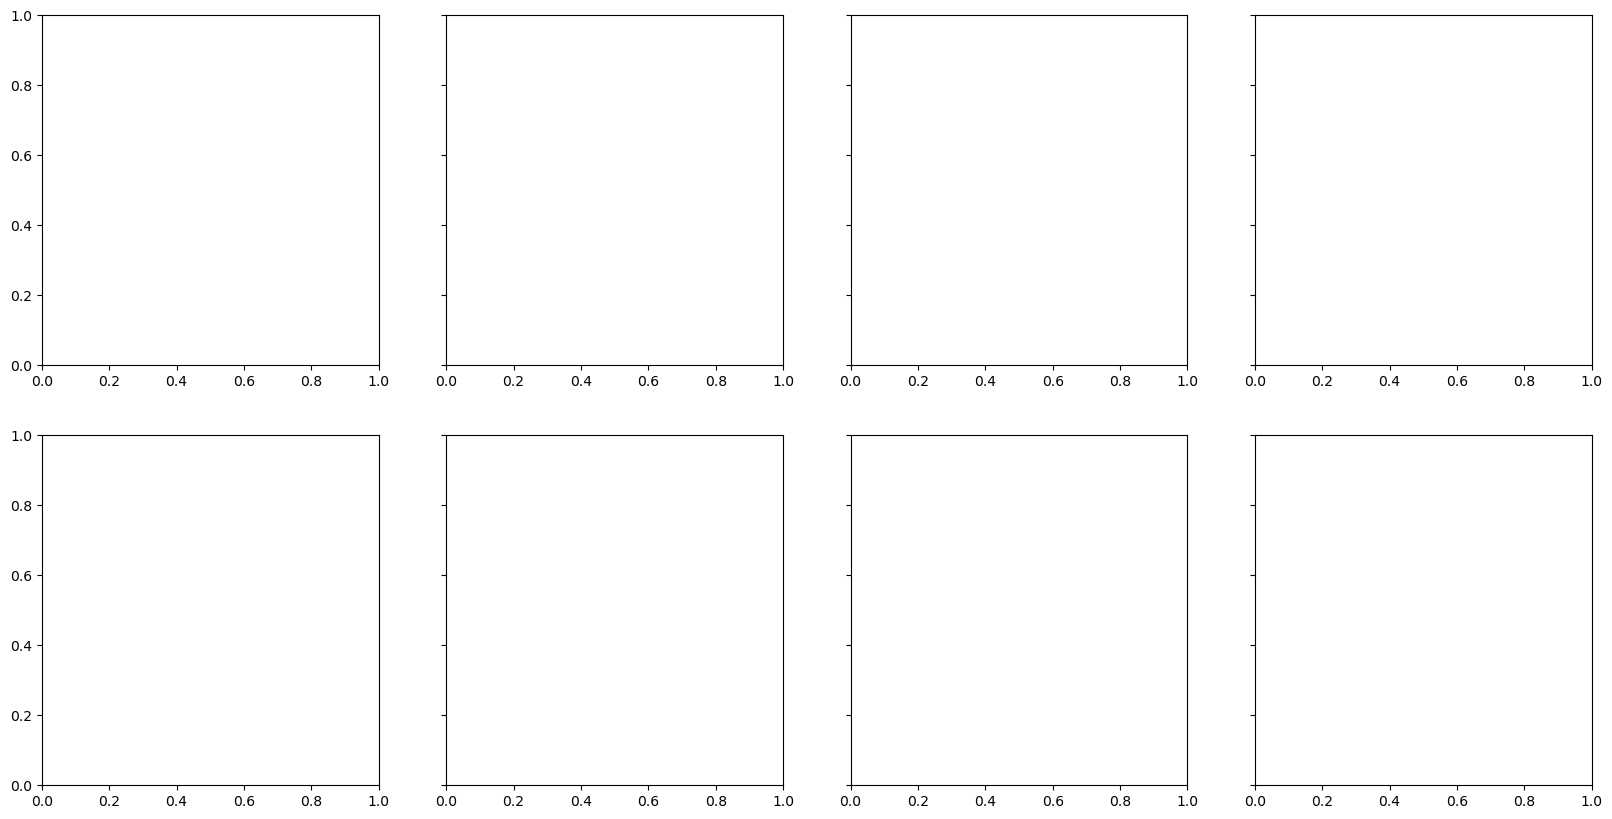

In [38]:


event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']

print(event_list)
con_data_df_clean=con_data_df[con_data_df['rat_id']!='dk3']
BWcontext_data=con_data_df[(con_data_df['task']=='BWcontext')]
BWnocontext_data=con_data_df[(con_data_df['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}


rat_list=np.unique(con_data_df['rat_id'])
print(rat_list)
fig, axs=plt.subplots(2,4, figsize=(20,10), sharey=True)
all_con_data=[]
all_con_data_mean=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
    #print(task_name)
    # for rat_num, rat_name in enumerate(rat_list):
    #     rat_task_data=task_data[task_data['rat_id']==rat_name]
        row=[task_name]
    #     #print(row)
        row_2=[task_name]
        for event in event_list:
            #print(event)
            event_epoch_list=task_data[event]
            aon_vHp_con=[]
            for event_epoch in event_epoch_list:
                    #print(row,event, event_epoch) 
                    fmin=1
                    fmax=100
                    freqs = np.arange(fmin,fmax)
                    n_cycles = freqs/2
                           
                    con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                         mode='cwt_morlet', cwt_freqs=freqs,
                                                         cwt_n_cycles=n_cycles, verbose=False, fmin=1, fmax=100, faverage=False)
                    coh = con.get_data(output='dense')
                    indices = con.names
                    

                    for i in range(coh.shape[0]):
                        for j in range(coh.shape[1]):
                            if 'AON' in indices[j] and 'vHp' in indices[i]:
                                aon_vHp_con.append(coh[i,j,:,:])
            row.append(np.mean(aon_vHp_con, axis=0))
            row_2.append(np.mean(aon_vHp_con))
        all_con_data.append(row)                    
        all_con_data_mean.append(row_2)
# Convert all_con_data to a DataFrame for easier manipulation
all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)

fs=2000


C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\1325762273.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vmin = all_con_data_df[event_list].applymap(np.min).min().min()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_52652\1325762273.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vmax = all_con_data_df[event_list].applymap(np.max).max().max()


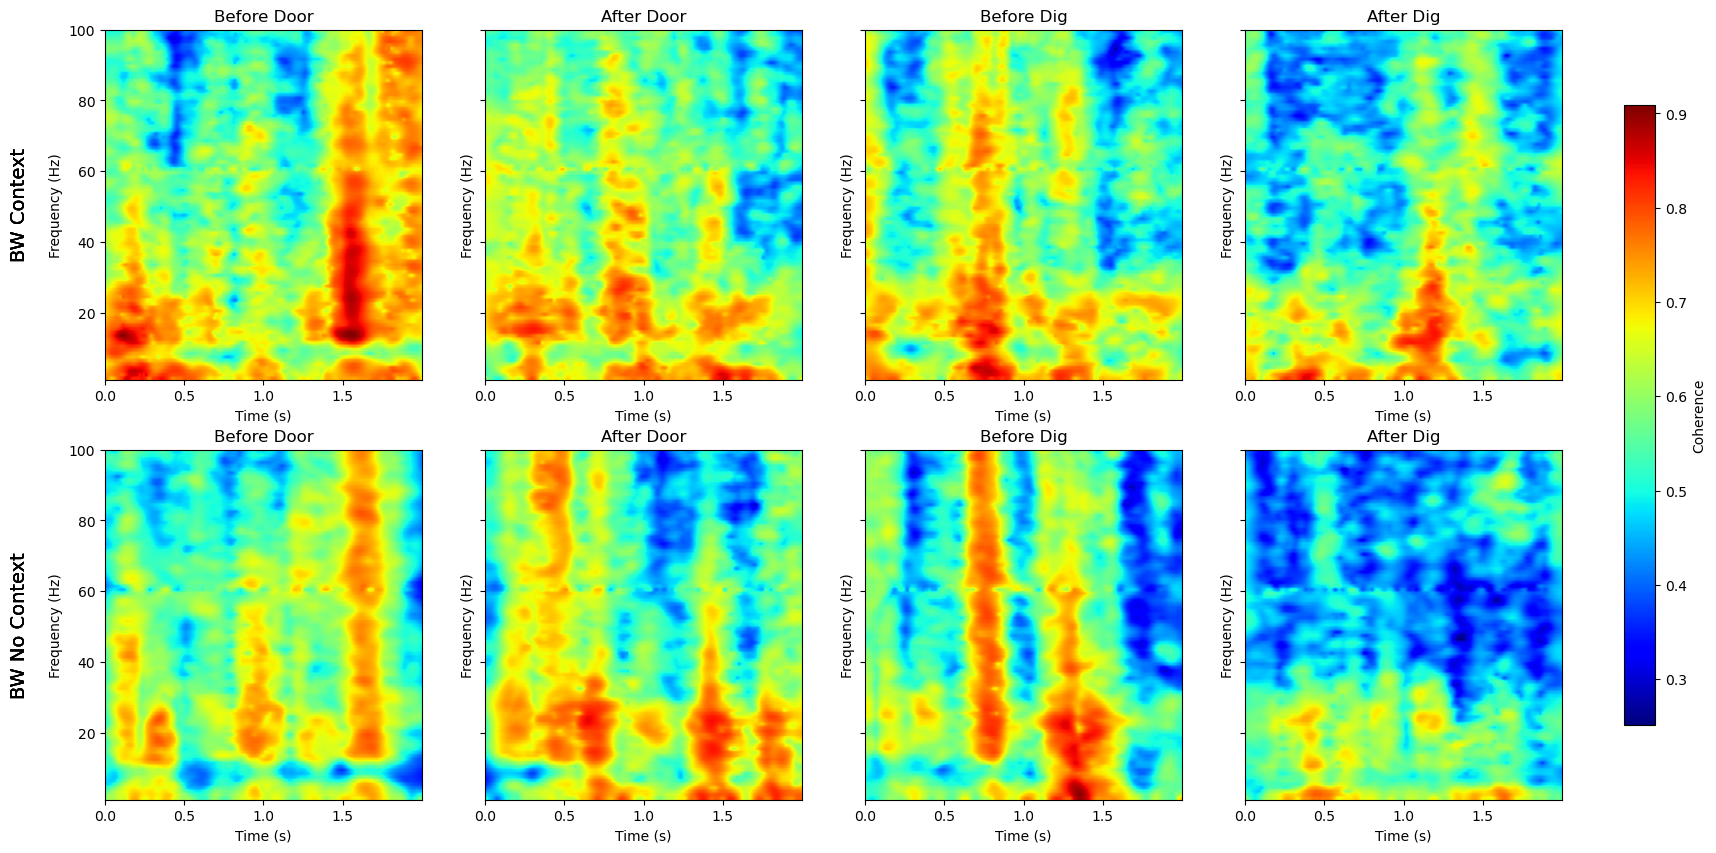

In [39]:

times=np.arange(0, 2, 1/fs)
fig, axs=plt.subplots(2,4, figsize=(20,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Before Door','After Door','Before Dig','After Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('Time (s)')
    axs[0,i].set_ylabel('Frequency (Hz)')
    axs[0,i].set_title(event_names[i])

    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)')
    axs[1,i].set_ylabel('Frequency (Hz)')
    axs[1,i].set_title(event_names[i])
    axs[0,0].text(-0.3, 0.5, 'BW Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.3, 0.5, 'BW No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence')
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_event_spectrogram.png', dpi=300)
plt.show()

In [ ]:

all_con_data_mean=pd.DataFrame(all_con_data_mean, columns=['task','before_door','after_door','before_dig','after_dig'])
import matplotlib.pyplot as plt
import seaborn as sns
# Filter out non-numeric columns
numeric_columns = all_con_data_mean.select_dtypes(include=[float, int]).columns

# Group by task and calculate the mean for each event
grouped_data = all_con_data_mean.groupby('task')[numeric_columns].mean()

# Extract the relevant columns and their names
columns_to_plot = grouped_data.columns
x_labels = columns_to_plot

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each task's mean values
for task in grouped_data.index:
    ax.plot(x_labels, grouped_data.loc[task, columns_to_plot], label=task)
    
# Overlay stripplot for individual values
# for task in grouped_data.index:
#     task_data = all_con_data_mean[all_con_data_mean['task'] == task]
#     for col in columns_to_plot:
#         sns.stripplot(x=[col] * len(task_data), y=task_data[col], ax=ax, jitter=True, label=None, hue=task_data['task'], alpha=0.5)

# Set the x-axis ticks and labels
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Add labels and title
ax.set_xlabel('Events')
ax.set_ylabel('Mean Coherence')
ax.set_title('Mean Coherence Gamma (30-80 Hz)')

# Add a legend
ax.legend(title='Task')

# Show the plot
plt.tight_layout()
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\mean_coherence_gamma.png')
plt.show()

8. Attempt to do this for individual rat

In [ ]:

event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']

print(event_list)

BWcontext_data=con_data_df[(con_data_df['task']=='BWcontext')]
BWnocontext_data=con_data_df[(con_data_df['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}


rat_list=np.unique(con_data_df['rat_id'])
print(rat_list)
rat_list=['dk1', 'dk5', 'dk6']
fig, axs=plt.subplots(2,4, figsize=(20,10), sharey=True)
all_con_data_mean=[]

for rat_id in rat_list:
    all_con_data=[]
    for task_num,task_name in enumerate(task_data_dict.keys()):
            
            task_data=task_data_dict[task_name]
        #print(task_name)
        # for rat_num, rat_name in enumerate(rat_list):
            rat_task_data=task_data[task_data['rat_id']==rat_id]
            row=[task_name]
            row_2=[rat_id,task_name]  
        # #print(row)
            
            for event in event_list:
                #print(event)
                event_epoch_list=list(rat_task_data[event])
                aon_vHp_con=[]
                for event_epoch in event_epoch_list:
                        #print(row,event, event_epoch)        
                        con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                            mode='cwt_morlet', cwt_freqs=freqs,
                                                            cwt_n_cycles=n_cycles, verbose=False, fmin=30, fmax=80)
                        coh = con.get_data(output='dense')
                        indices = con.names
                        

                        for i in range(coh.shape[0]):
                            for j in range(coh.shape[1]):
                                if 'AON' in indices[j] and 'vHp' in indices[i]:
                                    aon_vHp_con.append(coh[i,j,:,:])
                row.append(np.mean(aon_vHp_con, axis=0))
                row_2.append(np.mean(aon_vHp_con))
            all_con_data.append(row)                    
            all_con_data_mean.append(row_2)
    # Convert all_con_data to a DataFrame for easier manipulation
    all_con_data_df = pd.DataFrame(all_con_data, columns=[ 'task'] + event_list)
    times=np.arange(0, 2, 1/fs)
    fs=2000
    fig, axs=plt.subplots(2,4, figsize=(20,10), sharey=True)
    fig.suptitle(rat_id)
    vmin = all_con_data_df[event_list].applymap(np.min).min().min()
    vmax = all_con_data_df[event_list].applymap(np.max).max().max()
    event_names=['Before Door','After Door','Before Dig','After Dig']
    for i, event in enumerate(event_list):
        #if not all_con_data_df[event].isnull().all():
            axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], freqs[0], freqs[-1]],
                aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=1)
            axs[0,i].set_xlabel('Time (s)')
            axs[0,i].set_ylabel('Frequency (Hz)')
            axs[0,i].set_title(event_names[i])

            axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], freqs[0], freqs[-1]],
                        aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=1)
            axs[1,i].set_xlabel('Time (s)')
            axs[1,i].set_ylabel('Frequency (Hz)')
            axs[1,i].set_title(event_names[i])
            axs[0,0].text(-0.3, 0.5, 'BW Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
            axs[1,0].text(-0.3, 0.5, 'BW No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
        # Add a colorbar
    cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Coherence')

Calculating Granger Causality for a single Epoch

=============================== End of Working code ======================================

In [ ]:
### I will calculate average coherence for baseline across all rats

single_baseline_epoch=con_data_df['mne_baseline'].iloc[0]
print(single_baseline_epoch)
fmin=1
fmax=100
freqs = np.arange(fmin,fmax)
n_cycles = freqs/2

con=mne_connectivity.spectral_connectivity_time(single_baseline_epoch, method='coh', sfreq=int(fs), freqs=freqs,fmin=fmin, fmax=fmax, mode='cwt_morlet', verbose=True, n_cycles=n_cycles)
coh = con.get_data(output='dense')
print(coh.shape)

indices = con.names
aon_vhp_con=[]

for i in range(coh.shape[1]):
    for j in range(coh.shape[2]):
        if 'AON' in indices[j] and 'vHp' in indices[i]:
            aon_vhp_con.append(coh[0,i,j,:])

aon_vhp_con_mean=np.mean(aon_vhp_con, axis=0)

plt.plot(freqs, aon_vhp_con_mean, label='AON-vHp', color='blue')

####### This is working for a single experiment. Now we will attempt to average it across rats #################


In [ ]:
bwcontext_con_data_df=pd.DataFrame(bwcontext_con_data)
bwcontext_con_data = bwcontext_con_data_df.to_numpy()
print(bwcontext_con_data.shape)

bwcontext_con_data_mean=bwcontext_con_data_df.mean(axis=0)
print(bwcontext_con_data_mean.shape)

In [ ]:
# Ensure bwcontext_con_data is defined and contains lists
#bwcontext_con_data = [sublist for sublist in bwcontext_con_data if isinstance(sublist, list) and len(sublist) > 0]
#bwcontext_con_data=np.array(bwcontext_con_data, dtype=object)
bwcontext_con_data_mean=np.mean(bwcontext_con_data, axis=0)

bwnocontext_con_data = [sublist for sublist in bwnocontext_con_data if isinstance(sublist, list) and len(sublist) > 0]
bwnocontext_con_data=np.array(bwnocontext_con_data, dtype=object)
bwnocontext_con_data_mean=np.mean(bwnocontext_con_data, axis=0)

plt.plot(freqs, bwcontext_con_data_mean, label='BW Context', color='blue')
plt.plot(freqs, bwnocontext_con_data_mean, label='BW No Context', color='red')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.legend()

Interesting things are happening with Pre door stuff. So I will now attempt to plot pre door coherence across epochs

In [ ]:
single_rat_single_exp_data = con_data_df[(con_data_df['rat_id']=='dk1') & (con_data_df['task']=='BWcontext')]
pre_door_exp_data = single_rat_single_exp_data.iloc[0]['mne_epoch_door_before']
# If this is an MNE Epochs object or numpy array:
if hasattr(pre_door_exp_data, 'ch_names'):
    channel_names = pre_door_exp_data.ch_names
    print(channel_names)
else:
    # Try to get channel info from metadata if available
    try:
        channel_names = single_rat_single_exp_data.iloc[0]['channel_names']
    except:
        print("Could not find channel names directly. Please check the data structure.")

# Start from higher minimum frequency (e.g. 4 Hz) to avoid long wavelets
freqs = np.arange(4, 100)
fs = 2000
times = np.arange(0, 2, 1/fs)

# Use fixed number of cycles for lower frequencies and more cycles for higher frequencies
n_cycles = np.zeros(len(freqs))
n_cycles[freqs <= 30] = 3  # Use 3 cycles for lower frequencies
n_cycles[freqs > 30] = freqs[freqs > 30]/4  # More cycles for higher frequencies

for i, epoch in enumerate(pre_door_exp_data):
    print(epoch.shape)
    con = mne_connectivity.spectral_connectivity_time(
        epoch[None,:,:], 
        method='coh',
        sfreq=int(fs),
        freqs=freqs,
        n_cycles=n_cycles,
        verbose=True, 
        average=False
    )
    
    coh = con.get_data(output='dense')
    print(coh.shape)
    channel_names_2 = con.names    
    print(channel_names_2)
    for i in range(coh.shape[1]):
        for j in range(coh.shape[2]):
            if 'AON' in channel_names[j] and 'vHp' in channel_names[i]:
                print('something')
                #aon_vHp_con.append(coh[i,j,:,:])

In [ ]:
single_rat_single_exp_data=con_data_df[(con_data_df['rat_id']=='dk1') & (con_data_df['task']=='BWcontext')]
pre_door_exp_data=single_rat_single_exp_data.iloc[0]['mne_epoch_door_before']
print(pre_door_exp_data)
freqs = np.arange(1,100)
fs=2000
times = np.arange(0, 2, 1/fs)

n_cycles = freqs/2
channel_names = pre_door_exp_data.ch_names
n_epochs = len(pre_door_exp_data)
print(n_epochs)
fig,axs=plt.subplots(1,n_epochs, figsize=(100,5), sharey=True)
for epoch_num,epoch in enumerate(pre_door_exp_data):
    print(epoch.shape)
    aon_vHp_con=[]
    con = mne_connectivity.spectral_connectivity_epochs(epoch[None,:,:], method='coh', sfreq=int(fs),
                                                            mode='cwt_morlet', cwt_freqs=freqs,
                                                            cwt_n_cycles=n_cycles, verbose=False, fmin=1, fmax=100)
    coh = con.get_data(output='dense')
    indices = con.names
    print(coh.shape, indices)    
    for i in range(coh.shape[0]):
        for j in range(coh.shape[1]):
            if 'AON' in channel_names[j] and 'vHp' in channel_names[i]:
                print('something')
                aon_vHp_con.append(coh[i,j,:,:])
    aon_vHp_con=np.mean(aon_vHp_con, axis=0)
    axs[epoch_num].imshow(np.squeeze(aon_vHp_con), extent=[times[0], times[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=1)
    axs[epoch_num].set_xlabel('Time (s)')
    axs[epoch_num].set_ylabel('Frequency (Hz)')
    axs[epoch_num].set_title('Epoch {}'.format(epoch_num))
plt.show()
    

In [ ]:
from mne_connectivity import SpectralConnectivity
import matplotlib.pyplot as plt
epochs=pre_door_exp_data
# Parameters
fmin, fmax = 8.0, 12.0  # Frequency range of interest
sfreq = epochs.info['sfreq']  # Sampling frequency

# Compute connectivity for all epochs
for i, epoch in enumerate(epochs):
    con = SpectralConnectivity(
        epoch[None, :, :],  # Add dimension for single epoch
        method='coh',       # Coherence
        sfreq=sfreq,
        fmin=fmin,
        fmax=fmax,
        faverage=False,     # Keep time and frequency dimensions
        verbose=False
    )

    # Extract data and metadata
    freqs = con.attrs['freqs']  # Frequencies
    times = con.attrs['times']  # Times
    data = con.get_data(output='dense')  # Shape: (n_channels, n_channels, n_freqs, n_times)

    # Choose a channel pair (e.g., Ch1 and Ch2)
    ch1, ch2 = 0, 1
    coherence_data = data[ch1, ch2, :, :]  # Shape: (n_freqs, n_times)

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    plt.imshow(
        coherence_data,
        aspect='auto',
        origin='lower',
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        cmap='viridis'
    )
    plt.colorbar(label='Coherence')
    plt.title(f'Coherence Heatmap for Epoch {i + 1} (Ch{ch1 + 1} vs Ch{ch2 + 1})')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()


In [ ]:
from mne_connectivity import SpectroTemporalConnectivity
import numpy as np
import matplotlib.pyplot as plt

# Initialize connectivity object
con = SpectroTemporalConnectivity(
    data=epochs,
    method='coh',
    sfreq=epochs.info['sfreq'],
    fmin=1.0,
    fmax=40.0,
    n_jobs=1,
    verbose=False
)

# Calculate coherence
con.compute()

# Extract data and metadata
coh_data = con.get_data(output='dense')  # Shape: (n_pairs, n_freqs, n_times)
freqs = con.freqs
times = con.times

# Create heatmap for each channel pair
n_channels = len(epochs.ch_names)
fig, axs = plt.subplots(n_channels, n_channels, figsize=(20, 20))

for i in range(n_channels):
    for j in range(n_channels):
        im = axs[i, j].imshow(
            coh_data[i, j],
            aspect='auto',
            origin='lower',
            extent=[times[0], times[-1], freqs[0], freqs[-1]],
            cmap='jet'
        )
        axs[i, j].set_title(f'{epochs.ch_names[i]} - {epochs.ch_names[j]}')
        if i == n_channels-1:
            axs[i, j].set_xlabel('Time (s)')
        if j == 0:
            axs[i, j].set_ylabel('Frequency (Hz)')

# Add colorbar
fig.colorbar(im, ax=axs.ravel().tolist())
plt.tight_layout()
plt.show()

=============================================== End of Code ========================================================

In [ ]:
print(coh.shape)

Do this for each rat

In [ ]:

times=np.arange(0, 2, 1/fs)
fs=2000
fig, axs=plt.subplots(2,4, figsize=(20,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Before Door','After Door','Before Dig','After Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], freqs[0], freqs[-1]],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('Time (s)')
    axs[0,i].set_ylabel('Frequency (Hz)')
    axs[0,i].set_title(event_names[i])

    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], freqs[0], freqs[-1]],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)')
    axs[1,i].set_ylabel('Frequency (Hz)')
    axs[1,i].set_title(event_names[i])
    axs[0,0].text(-0.3, 0.5, 'BW Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.3, 0.5, 'BW No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence')

In [ ]:
import numpy as np
import pandas as pd


# Group by 'task' and calculate the mean for each column
BWcontext_data = all_con_data_df[all_con_data_df['task'] == 'BWcontext']
BWnocontext_data = all_con_data_df[all_con_data_df['task'] == 'BWnocontext']
task_data_dict = {'BWcontext': BWcontext_data, 'BWnocontext': BWnocontext_data}
for task_name in task_data_dict.keys():
    task_data = task_data_dict[task_name]
    # Initialize an empty list to store the values
    all_values = []

    # Iterate over each row in the task_data
    for index, row in task_data.iterrows():
        # Extract the stored values in each column and append to the list
        for event in event_list:
            if pd.all.notnull(row[event]):
                all_values.append(row[event])

    # Convert the list to a numpy array and take the mean
    all_values_array = np.array(all_values)
    task_averages = np.mean(all_values_array, axis=0)
    task_averages = task_data.mean()
    print(task_averages)


In [ ]:


for rati, rat_name in rat_list:

    rat_task_con_data=con_data_df[(con_data_df['rat_id']=='dk1') & (con_data_df['task']=='BWcontext')]
    mne_epoch_dig_before_list=list(rat_task_con_data['mne_epoch_dig_before'])
    aon_aon_con=[]
    aon_vHp_con=[]
    vHp_vHp_con=[]

    for epoch_data in mne_epoch_dig_before_list:
    #epoch_data=mne_epoch_dig_before
        print(epoch_data)
        con = mne_connectivity.spectral_connectivity_epochs(epoch_data, method='coh', sfreq=int(fs),
                                                        mode='cwt_morlet', cwt_freqs=freqs,
                                                        cwt_n_cycles=n_cycles, verbose=False)

        coh = con.get_data(output='dense')
        print(coh.shape)
        indices = con.names
        print("Connection indices:", indices)
        fig, axs = plt.subplots(coh.shape[0],coh.shape[1] , figsize=(20, 20), sharex=True, sharey=True)
        times = np.arange(0, 2, 1/fs)
        for i in range(coh.shape[0]):
            for j in range(coh.shape[1]):
                axs[i,j].imshow(np.squeeze(coh[i,j,:,:]), extent=[times[0], times[-1], freqs[0], freqs[-1]],
                aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
                axs[i,j].set_xlabel('Time (s)')
                axs[i,j].set_ylabel('Frequency (Hz)')
                axs[i,j].set_title('{} - {}'.format(indices[i], indices[j]))
                if 'AON' in indices[i] and 'AON' in indices[j]:
                    aon_aon_con.append(coh[i,j,:,:])
                elif 'AON' in indices[j] and 'vHp' in indices[i]:
                    aon_vHp_con.append(coh[i,j,:,:])
                elif 'vHp' in indices[i] and 'vHp' in indices[j]:
                    vHp_vHp_con.append(coh[i,j,:,:])

#### Average the connections and plot them

    def filtered_and_mean_con(con):
        print(' number of connections before filtering',len(con))
        filter_con=[x for x in con if x.any()>0]
        print('number of connections after filtering',len(filter_con))
        filter_con=np.array(filter_con)

        filter_con_mean=np.mean(filter_con, axis=0)
        return filter_con_mean
    con_dict={'aon_aon':aon_aon_con,'aon_vHp':aon_vHp_con,'vHp_vHp':vHp_vHp_con}
    fig, axs=plt.subplots(1,3, figsize=(20,5), sharey=True)
    axs=axs.flatten()
    for i, key in enumerate(con_dict):
        con=con_dict[key]
        con_mean=filtered_and_mean_con(con)
        axs[i].imshow(con_mean, extent=[times[0], times[-1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower', cmap='jet', vmin=coh.min(), vmax=coh.max())
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Frequency (Hz)')
        axs[i].set_title(key)
    plt.show()

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_reshaped = mne_epoch_door_before.reshape(-1, 4000)  # Reshape to (n_epochs * n_channels, n_times)
data_normalized = scaler.fit_transform(data_reshaped)
data_normalized = data_normalized.reshape(len(epochs), len(lfp_channels), 4000)  # Reshape back to (n_epochs, n_channels, n_times)

info = mne.create_info(ch_names=channels, sfreq=2000.0, ch_types='misc')



In [ ]:
# Create MNE EpochsArray
mne_epoch_door_before = mne.EpochsArray(data_normalized, info)

# Plot the data
fig = mne_epoch_door_before.plot(picks=np.arange(1, 8), n_epochs=10)


fig.show()

# info=mne.create_info(ch_names=channels,sfreq=2000.0,ch_types='misc')
# mne_epoch_door_before=mne.EpochsArray(mne_epoch_door_before,info)
# #fig,axs=plt.subplots(1,1,figsize=(30,10))
# fig=mne_epoch_door_before.plot(picks=np.arange(1,8),n_epochs=10)
# fig.show()

In [ ]:
!pip install mne_connectivity

In [ ]:
import mne
import mne_connectivity


In [ ]:
%matplotlib inline
print(coh.shape)
plt.imshow(np.squeeze(coh[,:,:]), extent=[0, 2, freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [ ]:
print(coh)

In [ ]:
coh = con.get_data()

fig, axs = plt.subplots(6, 6, figsize=(30, 30))
axs = axs.flatten()

for i in range(coh.shape[0]):
    im = axs[i].imshow(np.squeeze(coh[i, :, :]), extent=[0, 2, freqs[0], freqs[-1]],
                       aspect='auto', origin='lower', cmap='jet')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Frequency (Hz)')
    axs[i].set_title('Channel {}'.format(i))

# Add a colorbar
fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)

plt.tight_layout()
plt.show()